In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# import models
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout,AlphaDropout,GlobalAveragePooling2D
from keras.layers import LeakyReLU 
from keras.layers import Activation
from keras import optimizers
from keras.constraints import maxnorm
from keras_preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.applications.inception_v3 import inception_v3

Using TensorFlow backend.


In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# load data from google drive
base_dir = "/content/drive/My Drive/Colab Notebooks/imgdata_299"
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')
bestwt_file1 = os.path.join(base_dir,'model.best1_wts.hdf5')
bestwt_file2 = os.path.join(base_dir,'model.best2_wts.hdf5')
print(test_dir)

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/imgdata_299/test


In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import BatchNormalization
import keras.initializers as initz
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

# base_model.summary()


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# use inceptionV3 layer as base_model
out = base_model.output

# add on the FC layer and final classification layer
out = Flatten()(out)
out = Dense(1024, activation='relu', kernel_initializer=initz.he_uniform())(out)
out = Dropout(0.5)(out)
out = Dense(256, activation='relu', kernel_initializer=initz.he_uniform())(out)
out = Dropout(0.25)(out)
predictions = Dense(2,activation='softmax')(out)

# glue on final layer to InceptionV3 base_model
model = Model(inputs=base_model.input,output=predictions)

# check model
# model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


In [0]:
# train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:

no_frozen = no_trainable = 0

## freeze all layers up to and including mixed8
for layer in model.layers[:249]:
  layer.trainable = False
  no_frozen+=1
  
## train last layers, starting with conv2d_929 (Conv2D) to the end
for layer in model.layers[249:]:
  layer.trainable = True
  no_trainable+=1

print('#Frozen layers = ',no_frozen,' ;  #Trainable layers = ',no_trainable)

# check the complete model
# print(model.summary())

#Frozen layers =  249  ;  #Trainable layers =  68


In [0]:
# Using ImageDataGenerator to read images from directories
# all images will be rescaled to be between -1 & +1
# this is the preprocessing done by F. Chollet for the Inception_v3 network.

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=15,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                 #  vertical_flip=True,
                                   fill_mode='nearest') 
validation_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

trn_batch_size = 64
val_batch_size = 16
tst_batch_size = 1

In [0]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299,299),
    batch_size=trn_batch_size, # 64,
    class_mode='categorical')

Found 1600 images belonging to 2 classes.


In [0]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(299,299),
    batch_size=val_batch_size, # 32,
    class_mode ='categorical')

Found 384 images belonging to 2 classes.


In [0]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299,299),
    batch_size=tst_batch_size, # 200,
    class_mode='categorical')


Found 200 images belonging to 2 classes.


In [0]:
from keras import callbacks as cb

# stage1: parameter setup
es = cb.EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=50)
bestwgt = cb.ModelCheckpoint(filepath=bestwt_file1, monitor='val_acc', mode='max', verbose=0, save_best_only=True)
model.compile(optimizer=optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-4, nesterov=False), loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
# ---- 1st stage training
history = model.fit_generator(
    train_generator,
    steps_per_epoch=1600 // trn_batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=384 // val_batch_size,
    callbacks=[es, bestwgt], shuffle=True)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
25/25 [==============================] - 58s 2s/step - loss: 0.8833 - acc: 0.5388 - val_loss: 0.9027 - val_acc: 0.5000
Epoch 2/100
25/25 [==============================] - 32s 1s/step - loss: 0.8266 - acc: 0.5406 - val_loss: 0.7077 - val_acc: 0.5130
Epoch 3/100
25/25 [==============================] - 45s 2s/step - loss: 0.7405 - acc: 0.5719 - val_loss: 0.7488 - val_acc: 0.5052
Epoch 4/100
25/25 [==============================] - 46s 2s/step - loss: 0.6802 - acc: 0.6031 - val_loss: 0.7182 - val_acc: 0.5104
Epoch 5/100
25/25 [==============================] - 45s 2s/step - loss: 0.6475 - acc: 0.6412 - val_loss: 0.7481 - val_acc: 0.5156
Epoch 6/100
25/25 [==============================] - 45s 2s/step - loss: 0.6497 - acc: 0.6456 - val_loss: 0.7638 - val_acc: 0.5104
Epoch 7/100
25/25 [==============================] - 44s 2s/step - loss: 0.6285 - acc: 0.6512 - val_loss: 0.8361 - val_acc: 0.5026
Epoch 8/100
25/25 [================

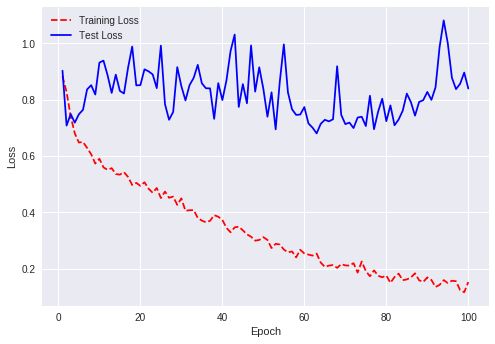

In [0]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


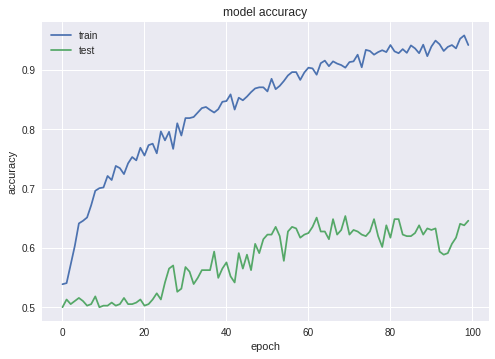

In [0]:
# # Plot Training History. 
# # list all data in history 
print(history.history.keys()) 

# summarize history for accuracy 
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report for Validation set
Y_pred = model.predict_generator(validation_generator, 384//val_batch_size,verbose=1)
print('-'* 60, '\n Validation images = ', len(Y_pred))
y_pred = np.argmax(Y_pred, axis=1)

print('\nConfusion Matrix (Validation Image set)')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cardiomegaly', 'No Finding']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

# Confution Matrix and Classification Report for Test Image set
Y_pred = model.predict_generator(test_generator, 200//tst_batch_size,verbose=2)
print('-'* 60, '\n Test images = ', len(Y_pred))
y_pred = np.argmax(Y_pred, axis=1)

print('\nConfusion Matrix (Test Image set)')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cardiomegaly', 'No Finding']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
print('-'*60)

24/24 [==============================] - 7s 289ms/step
------------------------------------------------------------ 
 Validation images =  384

Confusion Matrix (Validation Image set)
[[105  87]
 [105  87]]
Classification Report
              precision    recall  f1-score   support

Cardiomegaly       0.50      0.55      0.52       192
  No Finding       0.50      0.45      0.48       192

   micro avg       0.50      0.50      0.50       384
   macro avg       0.50      0.50      0.50       384
weighted avg       0.50      0.50      0.50       384

------------------------------------------------------------ 
 Test images =  200

Confusion Matrix (Test Image set)
[[69 31]
 [61 39]]
Classification Report
              precision    recall  f1-score   support

Cardiomegaly       0.53      0.69      0.60       100
  No Finding       0.56      0.39      0.46       100

   micro avg       0.54      0.54      0.54       200
   macro avg       0.54      0.54      0.53       200
weighted avg  

In [0]:
# stage2: training parameer setup
es = cb.EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=15)
bestwgt = cb.ModelCheckpoint(filepath=bestwt_file2, monitor='val_acc', mode='max', verbose=0, save_best_only=True)
model.compile(optimizer=optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-4, nesterov=False), loss='categorical_crossentropy', metrics=['accuracy'])


# ---- 2nd stage training
history = model.fit_generator(
    train_generator,
    steps_per_epoch=1600 // trn_batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=384 // val_batch_size,
    callbacks=[es, bestwgt], shuffle=True)

Epoch 1/50
25/25 [==============================] - 53s 2s/step - loss: 0.1357 - acc: 0.9500 - val_loss: 0.8270 - val_acc: 0.6536
Epoch 2/50
25/25 [==============================] - 43s 2s/step - loss: 0.1589 - acc: 0.9400 - val_loss: 0.8169 - val_acc: 0.6094
Epoch 3/50
25/25 [==============================] - 45s 2s/step - loss: 0.1483 - acc: 0.9381 - val_loss: 0.9181 - val_acc: 0.6172
Epoch 4/50
25/25 [==============================] - 45s 2s/step - loss: 0.1276 - acc: 0.9569 - val_loss: 0.9559 - val_acc: 0.5938
Epoch 5/50
25/25 [==============================] - 46s 2s/step - loss: 0.1413 - acc: 0.9469 - val_loss: 0.8319 - val_acc: 0.6406
Epoch 6/50
25/25 [==============================] - 45s 2s/step - loss: 0.1318 - acc: 0.9469 - val_loss: 0.8672 - val_acc: 0.6302
Epoch 7/50
25/25 [==============================] - 45s 2s/step - loss: 0.1474 - acc: 0.9425 - val_loss: 0.8075 - val_acc: 0.6328
Epoch 8/50
25/25 [==============================] - 45s 2s/step - loss: 0.1396 - acc: 0.94

In [0]:
#Confution Matrix and Classification Report for Validation set
Y_pred = model.predict_generator(validation_generator, 384//val_batch_size,verbose=1)
print('-'* 60, '\n Validation images = ', len(Y_pred))
y_pred = np.argmax(Y_pred, axis=1)

print('\nConfusion Matrix (Validation Image set)')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cardiomegaly', 'No Finding']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

# Confution Matrix and Classification Report for Test Image set
Y_pred = model.predict_generator(test_generator, 200//tst_batch_size,verbose=2)
print('-'* 60, '\n Test images = ', len(Y_pred))
y_pred = np.argmax(Y_pred, axis=1)

print('\nConfusion Matrix (Test Image set)')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cardiomegaly', 'No Finding']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
print('-'*60)



24/24 [==============================] - 7s 309ms/step
------------------------------------------------------------ 
 Validation images =  384

Confusion Matrix (Validation Image set)
[[ 87 105]
 [ 94  98]]
Classification Report
              precision    recall  f1-score   support

Cardiomegaly       0.48      0.45      0.47       192
  No Finding       0.48      0.51      0.50       192

   micro avg       0.48      0.48      0.48       384
   macro avg       0.48      0.48      0.48       384
weighted avg       0.48      0.48      0.48       384

------------------------------------------------------------ 
 Test images =  200

Confusion Matrix (Test Image set)
[[57 43]
 [54 46]]
Classification Report
              precision    recall  f1-score   support

Cardiomegaly       0.51      0.57      0.54       100
  No Finding       0.52      0.46      0.49       100

   micro avg       0.52      0.52      0.52       200
   macro avg       0.52      0.52      0.51       200
weighted avg  

In [0]:
# load best validation accuracy model weights from stage1
model.load_weights(bestwt_file1)
model.compile(optimizer=optimizers.SGD(lr=0.00005, momentum=0.9, decay=1e-5, nesterov=True),loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
#Confution Matrix and Classification Report for Validation set
Y_pred = model.predict_generator(validation_generator, 384//val_batch_size,verbose=1)
print('-'* 60, '\n Validation images = ', len(Y_pred))
y_pred = np.argmax(Y_pred, axis=1)

print('\nConfusion Matrix (Validation Image set)')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cardiomegaly', 'No Finding']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

# Confution Matrix and Classification Report for Test Image set
Y_pred = model.predict_generator(test_generator, 200//tst_batch_size,verbose=2)
print('-'* 60, '\n Test images = ', len(Y_pred))
y_pred = np.argmax(Y_pred, axis=1)

print('\nConfusion Matrix (Test Image set)')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cardiomegaly', 'No Finding']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
print('-'*60)

24/24 [==============================] - 8s 331ms/step
------------------------------------------------------------ 
 Validation images =  384

Confusion Matrix (Validation Image set)
[[ 74 118]
 [ 72 120]]
Classification Report
              precision    recall  f1-score   support

Cardiomegaly       0.51      0.39      0.44       192
  No Finding       0.50      0.62      0.56       192

   micro avg       0.51      0.51      0.51       384
   macro avg       0.51      0.51      0.50       384
weighted avg       0.51      0.51      0.50       384

------------------------------------------------------------ 
 Test images =  200

Confusion Matrix (Test Image set)
[[47 53]
 [45 55]]
Classification Report
              precision    recall  f1-score   support

Cardiomegaly       0.51      0.47      0.49       100
  No Finding       0.51      0.55      0.53       100

   micro avg       0.51      0.51      0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg  

In [0]:
from keras import callbacks as cb
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=17)
bestwgt = cb.ModelCheckpoint(filepath=bestwt_file2, monitor='val_acc', mode='max', verbose=0, save_best_only=True)

# continue training! starting point [best validation accuracy weight]. see if it improves?
model.compile(optimizer=optimizers.SGD(lr=0.00005, momentum=0.9, decay=1e-5, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

# ---- 3rd stage training
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch=1600 // trn_batch_size,
    epochs=80,
    validation_data=validation_generator,
    validation_steps=384 // val_batch_size,
    callbacks=[es, bestwgt])


Epoch 1/80
25/25 [==============================] - 54s 2s/step - loss: 0.0879 - acc: 0.9700 - val_loss: 0.8331 - val_acc: 0.6510
Epoch 2/80
25/25 [==============================] - 42s 2s/step - loss: 0.0865 - acc: 0.9675 - val_loss: 0.9343 - val_acc: 0.6224
Epoch 3/80
25/25 [==============================] - 44s 2s/step - loss: 0.1111 - acc: 0.9556 - val_loss: 0.9339 - val_acc: 0.6198
Epoch 4/80
25/25 [==============================] - 45s 2s/step - loss: 0.0968 - acc: 0.9650 - val_loss: 0.8978 - val_acc: 0.6328
Epoch 5/80
25/25 [==============================] - 44s 2s/step - loss: 0.1093 - acc: 0.9619 - val_loss: 0.9138 - val_acc: 0.6302
Epoch 6/80
25/25 [==============================] - 45s 2s/step - loss: 0.1050 - acc: 0.9625 - val_loss: 0.8988 - val_acc: 0.6276
Epoch 7/80
25/25 [==============================] - 44s 2s/step - loss: 0.0895 - acc: 0.9681 - val_loss: 0.9176 - val_acc: 0.6354
Epoch 8/80
25/25 [==============================] - 45s 2s/step - loss: 0.1118 - acc: 0.95

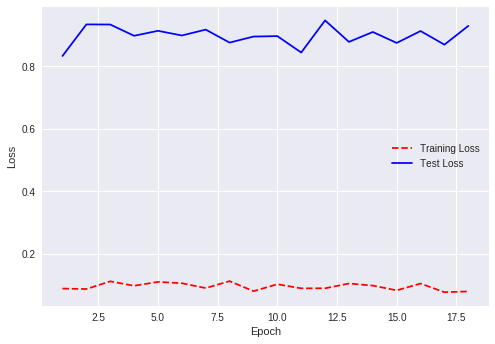

In [0]:
# Get training and test loss histories
training_loss = history2.history['loss']
test_loss = history2.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


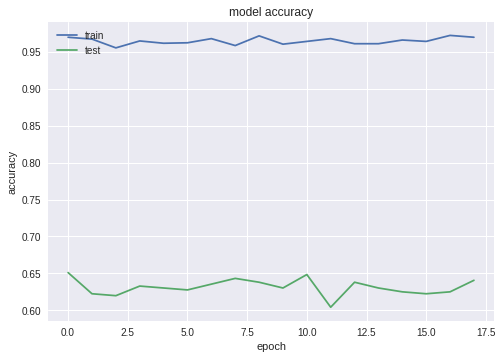

In [0]:
# Plot Training History. 
# list all data in history 
print(history2.history.keys()) 

# summarize history for accuracy 
plt.plot(history2.history['acc']) 
plt.plot(history2.history['val_acc']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [0]:
#Confution Matrix and Classification Report for Validation set
Y_pred = model.predict_generator(validation_generator, 384//val_batch_size,verbose=1)
print('-'* 60, '\n Validation images = ', len(Y_pred))
y_pred = np.argmax(Y_pred, axis=1)

print('\nConfusion Matrix (Validation Image set)')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cardiomegaly', 'No Finding']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

# Confution Matrix and Classification Report for Test Image set
Y_pred = model.predict_generator(test_generator, 200//tst_batch_size,verbose=2)
print('-'* 60, '\n Test images = ', len(Y_pred))
y_pred = np.argmax(Y_pred, axis=1)

print('\nConfusion Matrix (Test Image set)')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cardiomegaly', 'No Finding']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
print('-'*60)



24/24 [==============================] - 8s 320ms/step
------------------------------------------------------------ 
 Validation images =  384

Confusion Matrix (Validation Image set)
[[ 93  99]
 [ 82 110]]
Classification Report
              precision    recall  f1-score   support

Cardiomegaly       0.53      0.48      0.51       192
  No Finding       0.53      0.57      0.55       192

   micro avg       0.53      0.53      0.53       384
   macro avg       0.53      0.53      0.53       384
weighted avg       0.53      0.53      0.53       384

------------------------------------------------------------ 
 Test images =  200

Confusion Matrix (Test Image set)
[[50 50]
 [60 40]]
Classification Report
              precision    recall  f1-score   support

Cardiomegaly       0.45      0.50      0.48       100
  No Finding       0.44      0.40      0.42       100

   micro avg       0.45      0.45      0.45       200
   macro avg       0.45      0.45      0.45       200
weighted avg  